# Unmixing coercivity spectra from backfield curves

## Background on coercivity spectra

Natural samples contain ferromagnetic materials dispersed in paramagnetic and/or diamagnetic matrix material. Ferromagnetic mineral assemblages can be composed of minerals with different compositions, shapes, and sizes, such that they have different coercivities. Coercivity refers to the resistance of a ferromagnetic material to becoming demagnetized in the presence of an applied field. It is common in the fields of rock and environmental magnetism to use backfield magnetic remanence curves to gain insight into coercivity and thereby the ferromagnetic mineral assemblage within samples. Alternatively, a similar analysis can be conducted on isothermal remanent magnetization (IRM) acquisition or alternating field (AF) demagnetization data.

A backfield experiment is typically conducted on a vibrating sample magnetometer (VSM). In such an experiment, a strong external field is applied to the sample in one direction to induce a saturation isothermal remanent magnetization (sIRM), followed by the application of a field in the opposite direction. The process is repeated with the sIRM being applied, followed by reverse fields that are progressively larger in each step of the experiment. The derivative of the resultant backfield curve is referred to as the coercivity spectra. A common data analysis workflow is to fit components of this spectra to ‘unmix’ different populations of magnetic minerals.

Available programs for processing backfield coercivity curves include Max UnMix, IRM UnMix, GECA, IRM-CLG.

## Import scientific python libraries

Run the cell below to import the functions needed for the notebook.

In [1]:
import pmagpy.rockmag as rmag

import pmagpy.ipmag as ipmag
import pmagpy.contribution_builder as cb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Import data


In [2]:
# define the path to the folder 
dir_path = '../example_data/SSRM2024C'
# download the data from the MagIC database using my private contribution key 
result, magic_file = ipmag.download_magic_from_id('20433', directory=dir_path, share_key='e0bc04fd-8725-4aff-8687-75d51e741bcc')
# unpack the MagIC file
ipmag.unpack_magic(magic_file, dir_path, print_progress=False)
# get the contribution object
contribution = cb.Contribution(dir_path)
# get the measurements table
measurements = contribution.tables['measurements'].df
measurements = measurements.dropna(axis=1, how='all')
specimens = contribution.tables['specimens'].df

Download successful. File saved to: ../example_data/SSRM2024C/magic_contribution_20433.txt
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/contribution.txt
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/locations.txt
16  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/sites.txt
28  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/samples.txt
50  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/specimens.txt
16966  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/SSRM2024C/measurements.txt
-I- Using online data model
-I- Getting method codes from earthref.org
-I- Importing controlled vocabularies from https://earthref.org


## now let's extract the backfield experiment data (LP-BCR-BF) from the measurements table

- let's filter for the experiment with a protocol of `LP-BCR-BF` which stands for lab protocol-backfield coercivity remanence-backfield
- columns `magn_mass` and `treat_dc_field` contain the magnetization (mass normalized) and the applied back field respectively.

In [3]:
# filter for backfield measurements
backfield_measurements = measurements[measurements.method_codes == 'LP-BCR-BF']
# let's drop the empty columns
backfield_measurements = backfield_measurements.dropna(axis=1, how='all')
# let's inspec the data table
backfield_measurements.head()

,experiment,instrument_codes,magn_mass,measurement,method_codes,quality,specimen,standard,timestamp,treat_dc_field
measurement name,,,,,,,,,,
MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393701,IRM-VSM3-LP-BCR-BF-239370,IRM-VSM3,0.002470,MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393701,LP-BCR-BF,g,MA1-5-r gelcap,300,2024:06:06:15:41:00.00,-0.000070
MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393702,IRM-VSM3-LP-BCR-BF-239370,IRM-VSM3,0.001872,MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393702,LP-BCR-BF,g,MA1-5-r gelcap,300,2024:06:06:15:41:00.00,-0.005054
MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393703,IRM-VSM3-LP-BCR-BF-239370,IRM-VSM3,0.001353,MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393703,LP-BCR-BF,g,MA1-5-r gelcap,300,2024:06:06:15:41:00.00,-0.010090
MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393704,IRM-VSM3-LP-BCR-BF-239370,IRM-VSM3,0.000952,MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393704,LP-BCR-BF,g,MA1-5-r gelcap,300,2024:06:06:15:41:00.00,-0.015070
MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393705,IRM-VSM3-LP-BCR-BF-239370,IRM-VSM3,0.000591,MA1-5-r gelcapIRM-VSM3-LP-BCR-BF-2393705,LP-BCR-BF,g,MA1-5-r gelcap,300,2024:06:06:15:41:00.00,-0.020050


### We need to do some preprocessing on the raw data in order to unmix the spectrum

pick your own `smooth_frac` value between 0 and 1 for smoothing the raw backfield data

## Example 1

In [4]:
specimne_1 = 'SJ1-4-r gelcap'
experiment_1 = 'IRM-VSM4-LP-BCR-BF-239364'
smooth_frac = 0.0

selected_experiment = backfield_measurements[(backfield_measurements['specimen']==specimne_1) & 
                                      (backfield_measurements['experiment']==experiment_1)].reset_index(drop=1)
selected_experiment, specimen_1_Bcr = rmag.backfield_data_processing(selected_experiment, smooth_frac=smooth_frac)

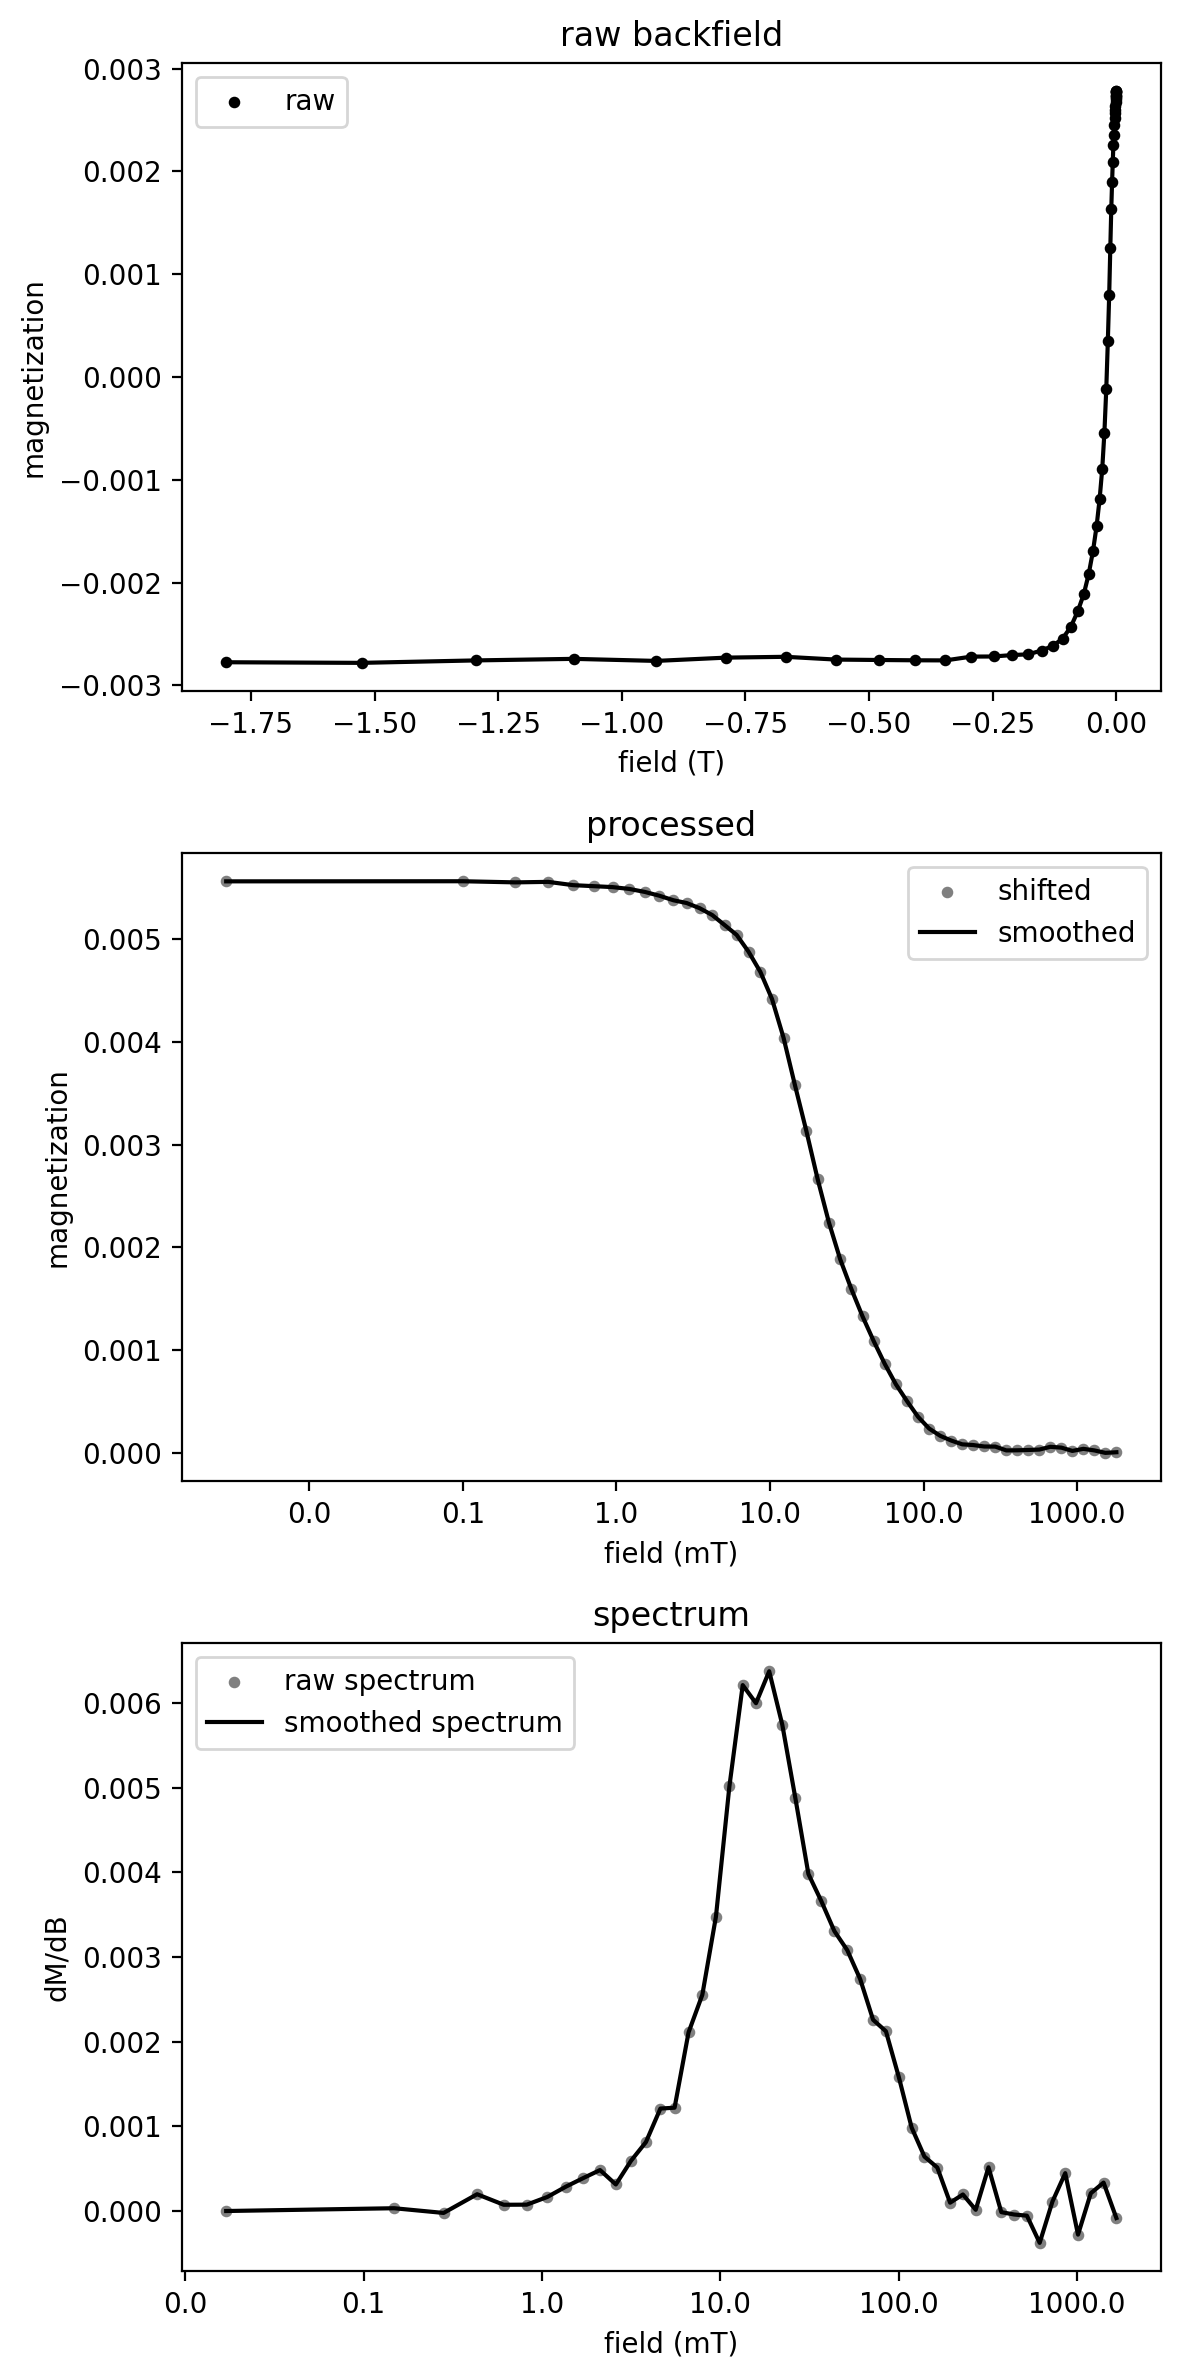

In [5]:
fig, (ax1, ax2, ax3) = rmag.plot_backfield_data(selected_experiment, figsize=(6, 12))

### set up initial guesses for skewnormal distribution parameters

- we need to set up a Pandas DataFrame table for the initial guesses of the skewnormal distribution parameters
- `amplitude` represents the relative height of the peak, i.e. the maximum amplitutde should be 1. 
- `center` represents the x axis value of the peak in unit of mT
- `sigma` represents the width of the peak in unit of mT
- `gamma` represents the skewness of the peak, should be between -1 and 1

In [6]:
parameters = pd.DataFrame({'amplitude': [0.5], 'center': [10], 'sigma': [10.0], 'gamma': [1]})
parameters

,amplitude,center,sigma,gamma
0,0.5,10,10.0,1


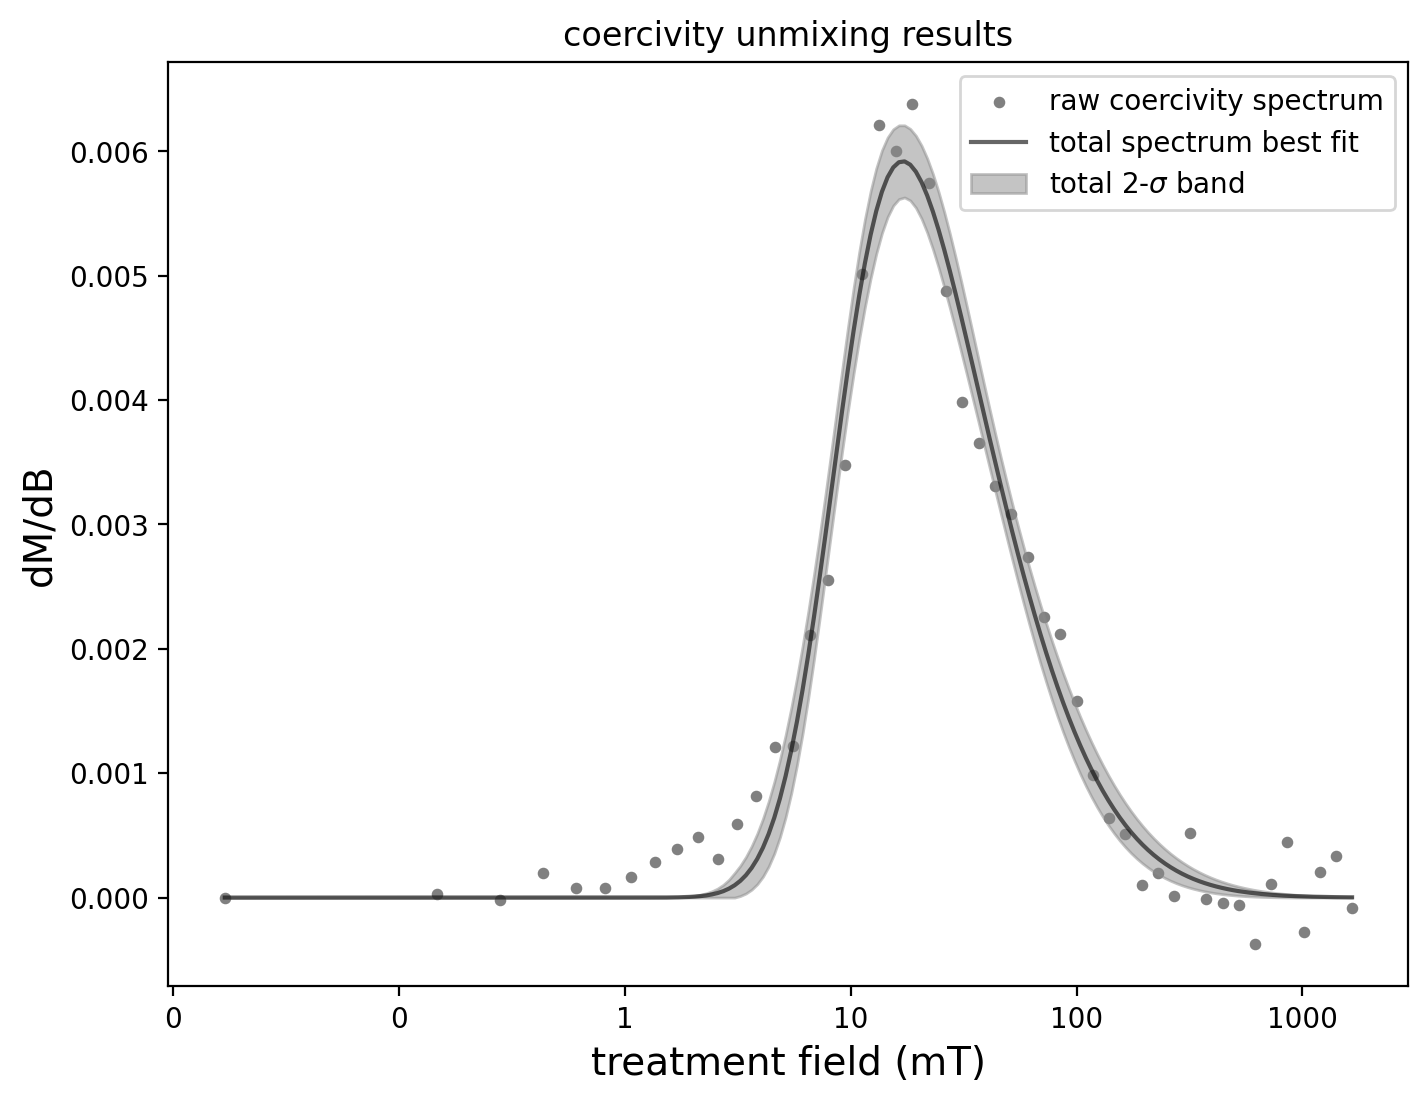

In [7]:
result, updated_parameters = rmag.backfield_unmixing(selected_experiment['smoothed_log_dc_field'], selected_experiment['smoothed_magn_mass_shift'], n_comps=1, parameters=parameters)
fig, ax = rmag.plot_backfield_unmixing_result(selected_experiment, result)

## Example 2

- we can also try to fit this data with two components

### set up initial guesses for skewnormal distribution parameters

- you need to set up your own Pandas DataFrame table for the initial guesses of the skewnormal distribution parameters
- the parameter table gets updated each time you run the unmixing algorithm

In [8]:
parameters = pd.DataFrame({'amplitude': [0.2, 0.7], 'center': [20, 50], 'sigma': [2, 2], 'gamma': [-1,1]})
parameters

,amplitude,center,sigma,gamma
0,0.2,20,2,-1
1,0.7,50,2,1


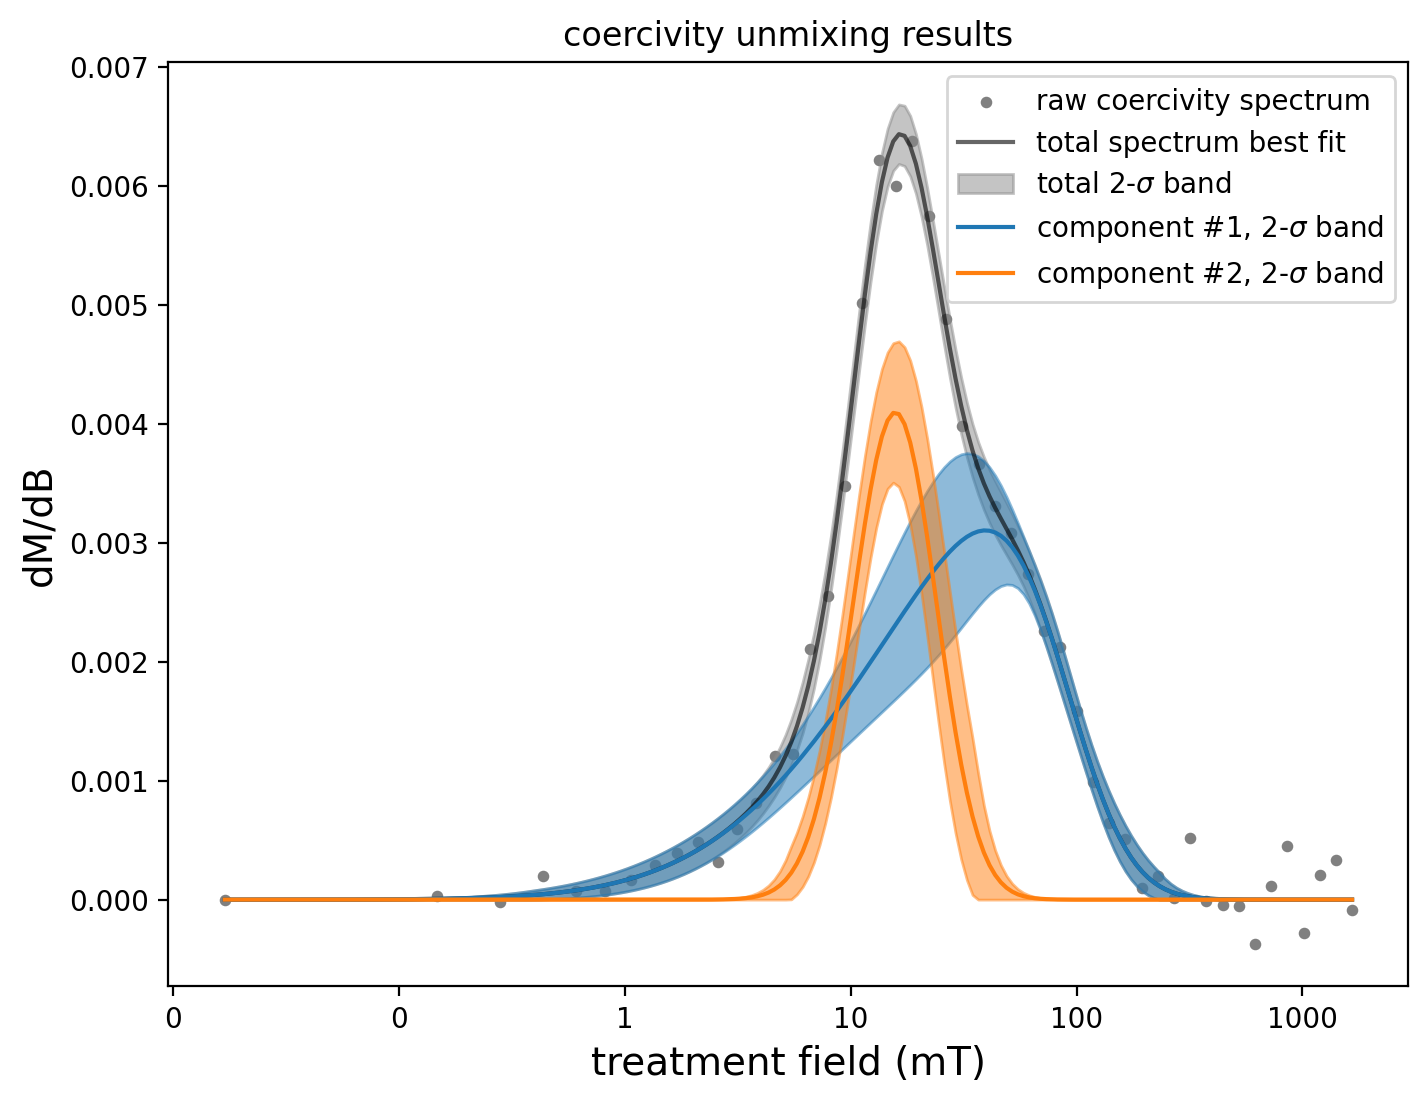

In [9]:
result, updated_parameters = rmag.backfield_unmixing(selected_experiment['smoothed_log_dc_field'], selected_experiment['smoothed_magn_mass_shift'], n_comps=2, parameters=parameters)
fig, ax = rmag.plot_backfield_unmixing_result(selected_experiment, result)

In [10]:
updated_parameters

,amplitude,center,sigma,gamma
0,0.562765,88.868127,6.019906,-3.362998
1,0.298851,19.597055,1.628651,-0.745458


## Example 3

In [11]:
specimne_2 = 'MA1-OX-r'
experiment_2 = 'IRM-VSM4-LP-BCR-BF-239379'
smooth_frac = 0.03

selected_experiment = backfield_measurements[(backfield_measurements['specimen']==specimne_2) & 
                                      (backfield_measurements['experiment']==experiment_2)].reset_index(drop=1)
selected_experiment, specimen_2_Bcr = rmag.backfield_data_processing(selected_experiment, smooth_frac=smooth_frac)

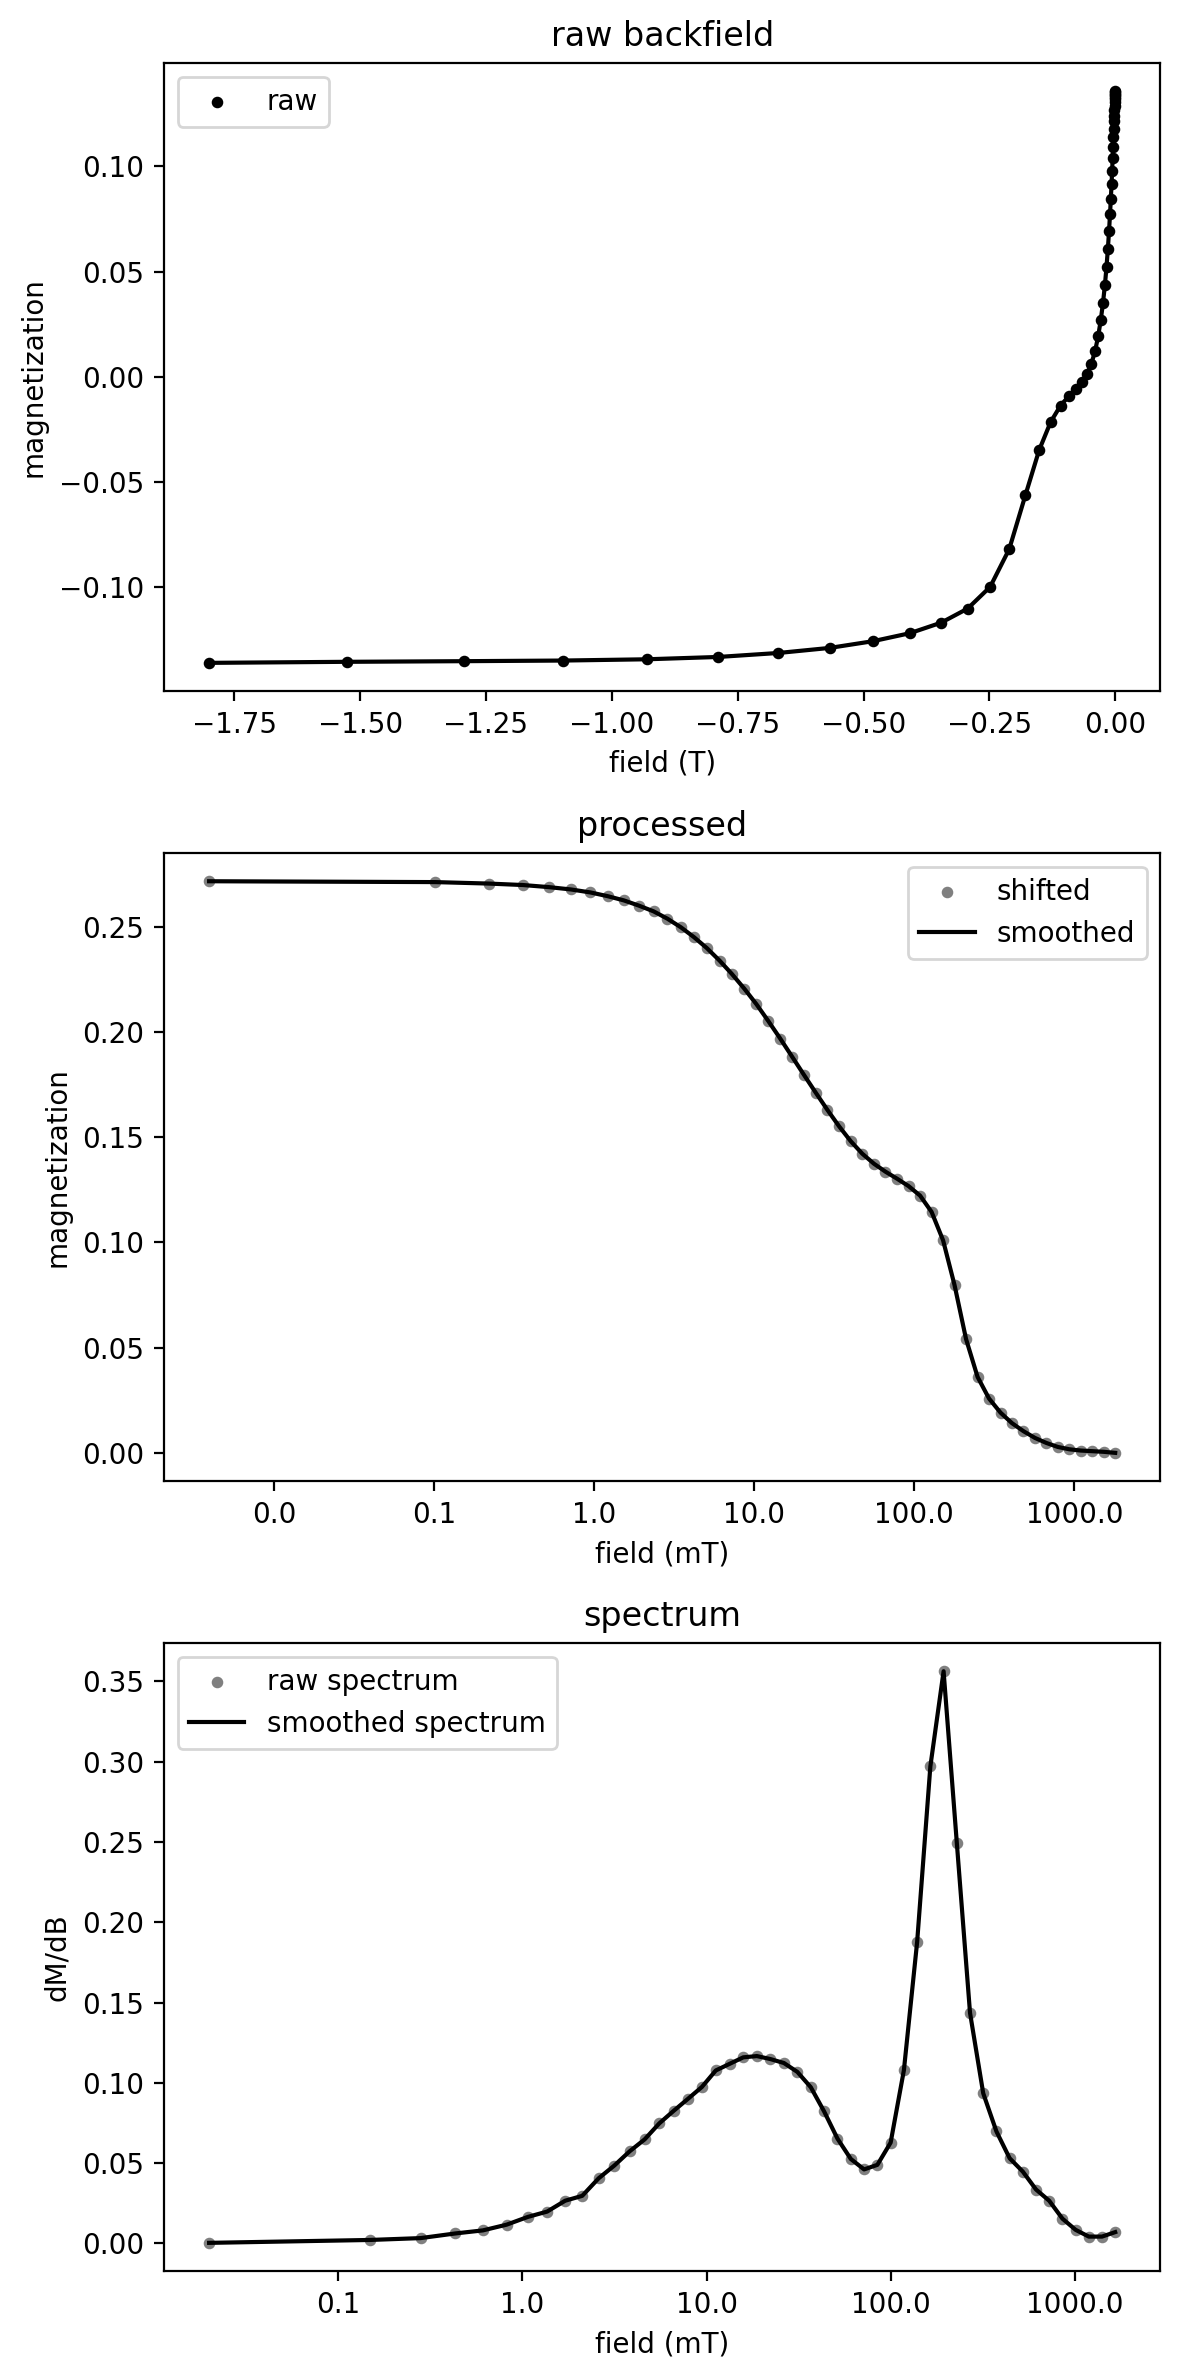

In [12]:
fig, (ax1, ax2, ax3) = rmag.plot_backfield_data(selected_experiment, figsize=(6, 12))

### set up initial guesses for skewnormal distribution parameters

- you need to set up your own Pandas DataFrame table for the initial guesses of the skewnormal distribution parameters
- the parameter table gets updated each time you run the unmixing algorithm

In [13]:
parameters = pd.DataFrame({'amplitude': [0.1, 0.3, 0.1], 'center': [10, 100, 1000], 'sigma': [3, 10, 50], 'gamma': [0, 0, 0]})
parameters

,amplitude,center,sigma,gamma
0,0.1,10,3,0
1,0.3,100,10,0
2,0.1,1000,50,0


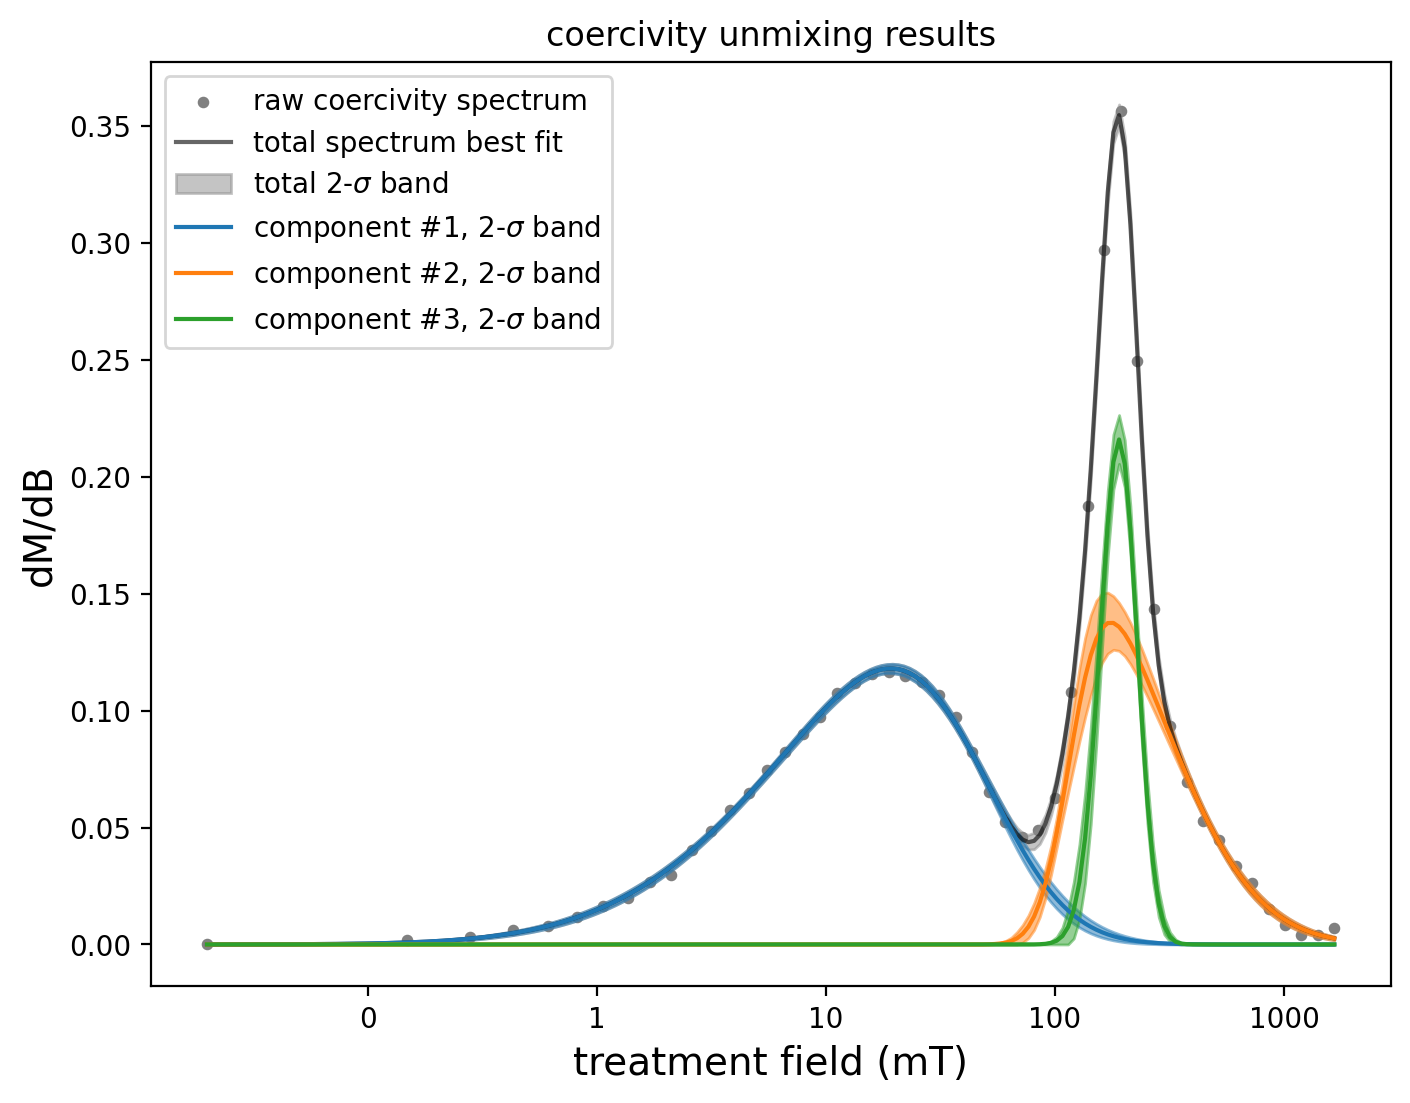

In [14]:
result, updated_parameters = rmag.backfield_unmixing(selected_experiment['smoothed_log_dc_field'], selected_experiment['smoothed_magn_mass_shift'], n_comps=3, parameters=parameters)
fig, ax = rmag.plot_backfield_unmixing_result(selected_experiment, result)

# report parameter median and standard deviation as MaxUnmix does

In [15]:
rmag.add_unmixing_stats_to_specimens_table(specimens, 'IRM-VSM4-LP-BCR-BF-239364', result)

In [16]:
specimens

,azimuth,description,dip,experiments,hyst_bc,hyst_bc_offset,hyst_bcr,hyst_mr_mass,hyst_ms_mass,hyst_xhf,...,method_codes,rem_hirm_mass,rem_sratio,rem_sratio_back,rem_sratio_forward,result_quality,sample,specimen,volume,weight
specimen name,,,,,,,,,,,,,,,,,,,,,
HH8-1-r,181.3,Haliburton Highlands 8-1 VSM specimen,43.0,None,NaN,NaN,NaN,NaN,NaN,NaN,...,None,NaN,NaN,NaN,NaN,g,HH8-3,HH8-1-r,0.000001,0.000072
HH8-1x,181.3,Haliburton Highlands 8-1 X-T specimen,43.0,None,NaN,NaN,NaN,NaN,NaN,NaN,...,None,NaN,NaN,NaN,NaN,g,HH8-3,HH8-1x,0.000001,0.000181
HH8-3b,181.3,Haliburton Highlands 8-3 core,43.0,None,NaN,NaN,NaN,NaN,NaN,NaN,...,None,NaN,NaN,NaN,NaN,g,HH8-3,HH8-3b,0.000000,0.000000
MA1-1b,211.7,MA1-1 core,56.0,None,NaN,NaN,NaN,NaN,NaN,NaN,...,None,NaN,NaN,NaN,NaN,g,MA1-1,MA1-1b,0.000000,0.015202
MA1-2-r,222.7,MA1-2 VSM specimen,56.0,None,NaN,NaN,NaN,NaN,NaN,NaN,...,None,NaN,NaN,NaN,NaN,g,MA1-2,MA1-2-r,0.000001,0.000081
MA1-2b,222.7,MA1-2 core,56.0,None,NaN,NaN,NaN,NaN,NaN,NaN,...,None,NaN,NaN,NaN,NaN,g,MA1-2,MA1-2b,0.000000,0.015471
MA1-2x,222.7,MA1-2 X-T specimen,56.0,None,NaN,NaN,NaN,NaN,NaN,NaN,...,None,NaN,NaN,NaN,NaN,g,MA1-2,MA1-2x,0.000001,0.000146
MA1-3b,215.7,MA1-3 core,49.0,None,NaN,NaN,NaN,NaN,NaN,NaN,...,None,NaN,NaN,NaN,NaN,g,MA1-3,MA1-3b,0.000000,0.015741
MA1-5-r gelcap,NaN,gel cap for MPMS,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,...,None,NaN,NaN,NaN,NaN,g,MA1-5-r,MA1-5-r gelcap,0.000000,0.000090
